
=== Analysis for llb3 ===
Total unique labels across all folds: 21

=== Analysis for llb16 ===
Total unique labels across all folds: 31

=== Analysis for llb11 ===
Total unique labels across all folds: 27

Visualization saved as label_presence_visualization.png


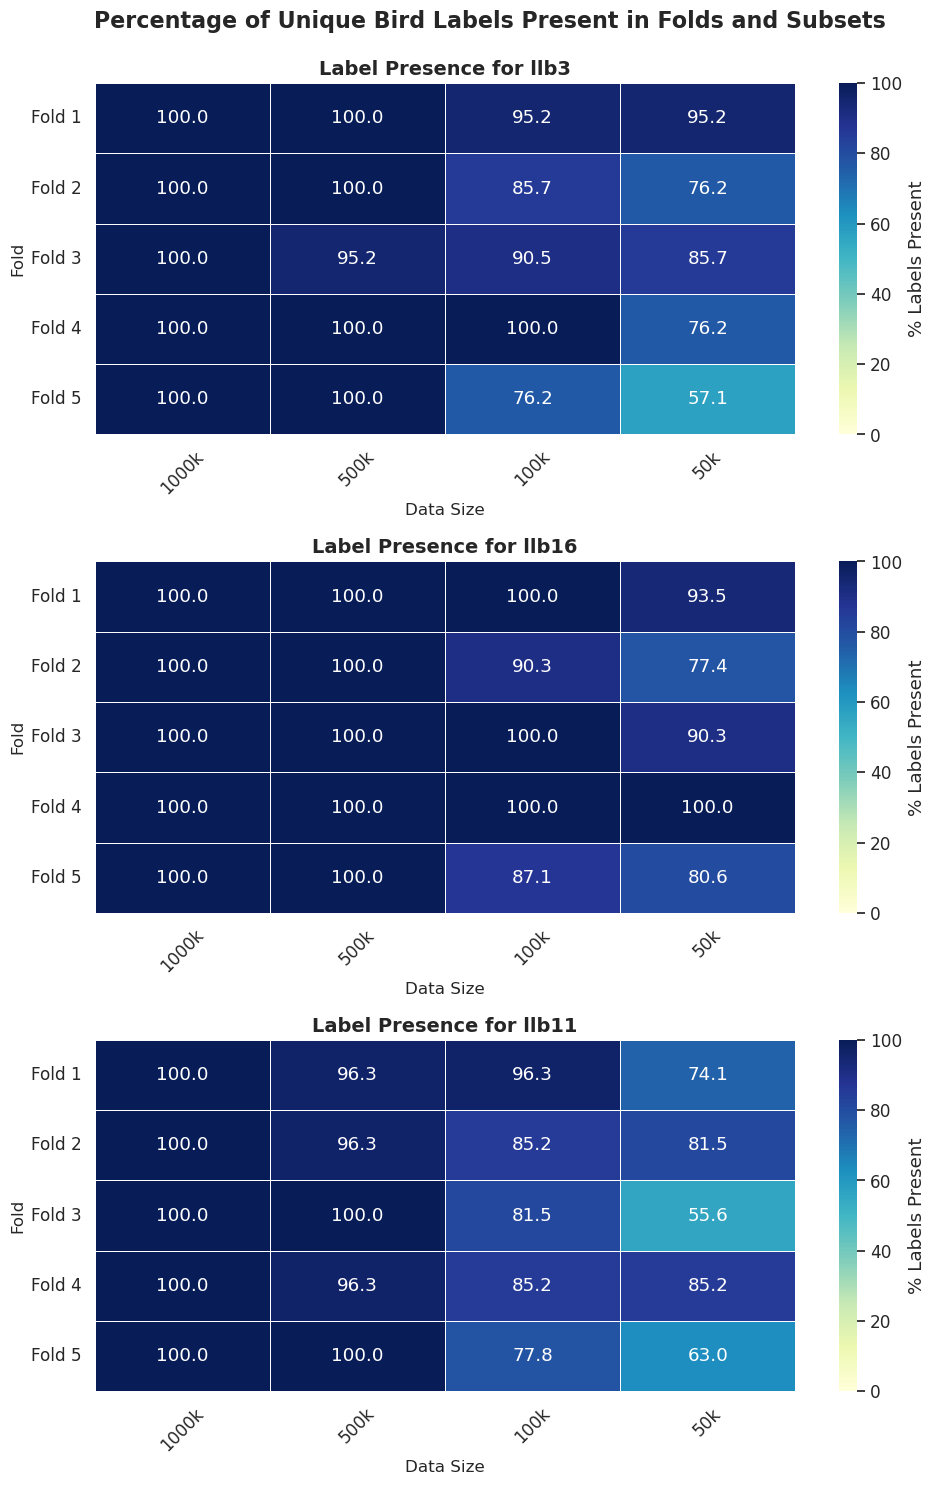

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def create_label_presence_visualization():
    """
    Analyzes label presence in dataset folds and subsets,
    then generates heatmaps to visualize the findings.
    """
    files = [
        "llb3_fold2.npz", "llb3_fold4.npz", "llb3_fold1.npz",
        "llb3_fold3.npz", "llb3_fold5.npz",
        "llb16_fold2.npz", "llb16_fold4.npz", "llb16_fold1.npz",
        "llb16_fold3.npz", "llb16_fold5.npz", "llb11_fold2.npz",
        "llb11_fold4.npz", "llb11_fold1.npz", "llb11_fold3.npz",
        "llb11_fold5.npz"
    ]

    bird_names = ["llb3", "llb16", "llb11"]
    
    # IMPORTANT: Adjust this path if your files are located elsewhere
    file_path_prefix = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/" 

    # Store results for plotting
    plot_data = []

    # First pass: collect all labels for each bird across all folds
    all_labels_per_bird = {}
    for bird in bird_names:
        all_labels = set()
        bird_files = [f for f in files if f.startswith(bird)]
        if not bird_files:
            print(f"Warning: No files found for bird {bird}. Skipping.")
            continue
        for file_name in bird_files:
            try:
                f = np.load(file_path_prefix + file_name)
                ground_truth_labels = f['ground_truth_labels']
                unique_labels = set(np.unique(ground_truth_labels))
                all_labels.update(unique_labels)
            except FileNotFoundError:
                print(f"Error: File not found - {file_path_prefix + file_name}. Please check the path.")
                return
            except Exception as e:
                print(f"Error loading or processing {file_name}: {e}")
                return
        all_labels_per_bird[bird] = all_labels
        if not all_labels:
             print(f"Warning: No labels found for bird {bird} across all its files.")


    # Second pass: analyze and collect data for plotting
    subset_sizes = [1000000, 500000, 100000, 50000]
    data_types_ordered = [f'{s//1000}k' for s in subset_sizes]

    for bird in bird_names:
        if bird not in all_labels_per_bird or not all_labels_per_bird[bird]:
            print(f"Skipping analysis for {bird} due to previous errors or no labels found.")
            continue

        total_labels_for_bird_set = all_labels_per_bird[bird]
        num_total_labels = len(total_labels_for_bird_set)
        if num_total_labels == 0:
            print(f"Warning: Bird {bird} has no unique labels across all folds. Cannot calculate percentages.")
            continue

        print(f"\n=== Analysis for {bird} ===")
        print(f"Total unique labels across all folds: {num_total_labels}")
        # print(f"Labels: {sorted(total_labels_for_bird_set)}") # Optional: print all labels

        bird_files = [f for f in files if f.startswith(bird)]
        for file_name in bird_files:
            fold_num_str = file_name.split('_fold')[1].split('.')[0]
            fold_key = f"Fold {fold_num_str}"
            
            try:
                f = np.load(file_path_prefix + file_name)
                ground_truth_labels = f['ground_truth_labels']
            except Exception as e:
                print(f"Error loading {file_name} during second pass: {e}")
                continue

            # Subset analysis for each size
            for i, subset_size in enumerate(subset_sizes):
                data_type_key = data_types_ordered[i] # e.g., '1000k', '500k'
                if len(ground_truth_labels) >= subset_size:
                    subset_labels = ground_truth_labels[:subset_size]
                    subset_unique_labels_set = set(np.unique(subset_labels))
                    num_present_subset = len(subset_unique_labels_set)
                    percentage_present_subset = (num_present_subset / num_total_labels) * 100 if num_total_labels > 0 else 0
                    plot_data.append({
                        'bird': bird,
                        'fold': fold_key,
                        'data_type': data_type_key,
                        'percentage_present': percentage_present_subset,
                        'num_present': num_present_subset,
                        'num_total_bird_labels': num_total_labels
                    })
                else: # Not enough data for this subset
                    plot_data.append({
                        'bird': bird,
                        'fold': fold_key,
                        'data_type': data_type_key,
                        'percentage_present': np.nan, # Use NaN for missing data
                        'num_present': np.nan,
                        'num_total_bird_labels': num_total_labels
                    })
    
    if not plot_data:
        print("No data collected for plotting. Exiting visualization.")
        return

    df = pd.DataFrame(plot_data)

    # --- Plotting ---
    sns.set_theme(style="whitegrid", font_scale=1.1)
    
    num_birds = len(bird_names)
    fig, axes = plt.subplots(num_birds, 1, figsize=(10, 5 * num_birds), squeeze=False) # Ensure axes is always 2D
    axes = axes.flatten() # Flatten to 1D array for easier iteration

    for i, bird in enumerate(bird_names):
        ax = axes[i]
        bird_df = df[df['bird'] == bird].copy()

        if bird_df.empty:
            ax.set_title(f"Label Presence for canary id:{bird} (No data to display)", fontsize=14, fontweight='bold')
            ax.text(0.5, 0.5, "No data available for this bird.", 
                    horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        # Ensure 'fold' is sorted correctly (e.g., Fold 1, Fold 2, ... Fold 10 not Fold 1, Fold 10, Fold 2)
        bird_df['fold_sort_key'] = bird_df['fold'].str.extract(r'(\d+)').astype(int)
        bird_df = bird_df.sort_values(by=['fold_sort_key'])
        
        pivot_table = bird_df.pivot_table(
            index='fold', 
            columns='data_type', 
            values='percentage_present',
            sort=False # Use the order from sorted bird_df
        )
        
        # Reorder columns to match data_types_ordered
        pivot_table = pivot_table.reindex(columns=data_types_ordered)

        sns.heatmap(
            pivot_table, 
            annot=True, 
            fmt=".1f", 
            cmap="YlGnBu", # A good sequential colormap (Yellow-Green-Blue)
            linewidths=.5, 
            ax=ax,
            cbar_kws={'label': '% Labels Present'},
            vmin=0,  # Explicitly set range for consistency
            vmax=100
        )
        ax.set_title(f"Label Presence for {bird}", fontsize=14, fontweight='bold')
        ax.set_ylabel("Fold", fontsize=12)
        ax.set_xlabel("Data Size", fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)

    plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout to prevent title overlap
    fig.suptitle("Percentage of Unique Bird Labels Present in Folds and Subsets", fontsize=16, fontweight='bold', y=0.99)
    
    # Save the figure
    output_filename = "label_presence_visualization.png"
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"\nVisualization saved as {output_filename}")
    plt.show()

if __name__ == '__main__':
    create_label_presence_visualization()